## Обработка графиков ЭКГ и преобразование в таблицу

In [100]:
import pywt
import os
from pylab import *
from numpy import*
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def get_ecg(key): # получение закодированного графика экг из файла
    way = 'train/' + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [4]:
def into_one_table(keys): # преобразование графиков в таблицу
    row = get_ecg(keys[0])
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i])
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [10]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-2])))
ECG_data = into_one_table(target) # таблица с графиками

In [11]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'ecg_id'})

In [12]:
ECG_data = ECG_data.sort_values(by=['ecg_id'], ascending=True)

In [13]:
ECG_data 

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


## N-граммы

In [14]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [15]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [16]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [17]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [18]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [19]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [20]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [21]:
ECG_data_array = np.array(ECG_data)

In [22]:
R_Peaks = []

In [23]:
ecg_ids = []
encoding_ecgs = []

In [24]:
for ecgsignal in ECG_data_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids.append(ecg_id)
    encoding_ecgs.append(encoding_ecg) 

In [25]:
encoding_ecg = pd.Series(encoding_ecgs, index=ecg_ids)

In [26]:
gts = pd.read_csv('train/train_gts.csv')  # данные из файла train_gts.csv
gts.record_name = gts.record_name.map(lambda x: float(x[:-3]))
gts = gts.sort_values(by='record_name')
gts.insert(2, 'encoding_ecg', array(encoding_ecg))
gts

,record_name,myocard,encoding_ecg
265,9.0,0,DDCADDCC
1407,34.0,0,DDDCCCFFFDDFCCCACFE
1833,43.0,0,BFABCFADDEC
441,52.0,0,DDEFBCCBCCF
1834,57.0,0,DDCADBCDD
...,...,...,...
1753,21784.0,0,DDCCFFAFAFFAFC
2008,21795.0,0,
72,21825.0,0,ECCDDDECB
2100,21831.0,0,DAFCCDDDCFCD


In [27]:
sick = gts[gts.myocard == 1].encoding_ecg  # закодированные кардиограммы больных
healthy = gts[gts.myocard == 0].encoding_ecg  # закодированные кардиограммы здоровых

In [28]:
sp_sick= []  # список N-грамм больных
for i in sick:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_sick.append(k)

In [29]:
sp_healthy = []  # список N-грамм здоровых
for i in healthy:
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
    for k in n:
        sp_healthy.append(k)

In [30]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [31]:
q_sick = counter_and_sort(sp_sick) # отсортированные н-граммы больных
q_health = counter_and_sort(sp_healthy)  # отсортированные н-граммы здоровых

In [32]:
only_sick = list(set(q_sick.index) - set(q_health.index)) # н-граммы, встречающиеся только у больных
only_health = list(set(q_health.index) - set(q_sick.index)) # н-граммы, встречающиеся только у здоровых

In [33]:
popular_sick = q_sick.iloc[:len(q_sick) // 2] # н-граммы, чаще всего встречающиеся у больных
popular_health = q_health.iloc[:len(q_health) // 2] # н-граммы, чаще всего встречающиеся у здоровых

In [34]:
# н-граммы, которые чаще всего встречаются у больных и не встречаются у здоровых
popular_sick_only = list(set(popular_sick.index) - set(popular_health.index))

# н-граммы, которые чаще всего встречаются у здоровых и не встречаются у больных
popular_health_only = list(set(popular_health.index) - set(popular_sick.index))

In [36]:
ngramms_ecgs = []  # список н-грамм в кардиограммах
for ecg in array(gts):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[2]), 6))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs.append(list(ngramms_ecg))

In [37]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    ng_health = sum(list(map(lambda x: 1 if x in only_health else 0, ng)))
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))

    ng_popular_health = sum(list(map(lambda x: 1 if x in popular_health_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))

    return [ng_health, ng_sick, ng_popular_health, ng_popular_sick]

In [38]:
arr = pd.DataFrame([func(ng) for ng in ngramms_ecgs]) 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(arr, gts.myocard, random_state=0, test_size=0.75)
# разбиение на тестовый и тренировочный датасет

In [40]:
cat_n_gramms = CatBoostClassifier(depth=9,  learning_rate=0.03)
cat_n_gramms.fit(X_train, y_train)

0:	learn: 0.6444023	total: 121ms	remaining: 2m
1:	learn: 0.6138423	total: 124ms	remaining: 1m 1s
2:	learn: 0.5774073	total: 128ms	remaining: 42.4s
3:	learn: 0.5306864	total: 130ms	remaining: 32.3s
4:	learn: 0.4964606	total: 133ms	remaining: 26.5s
5:	learn: 0.4700599	total: 137ms	remaining: 22.7s
6:	learn: 0.4540542	total: 139ms	remaining: 19.7s
7:	learn: 0.4295647	total: 141ms	remaining: 17.5s
8:	learn: 0.4147643	total: 144ms	remaining: 15.8s
9:	learn: 0.3949265	total: 147ms	remaining: 14.5s
10:	learn: 0.3697582	total: 149ms	remaining: 13.4s
11:	learn: 0.3527951	total: 152ms	remaining: 12.5s
12:	learn: 0.3357232	total: 156ms	remaining: 11.8s
13:	learn: 0.3178687	total: 159ms	remaining: 11.2s
14:	learn: 0.3044209	total: 163ms	remaining: 10.7s
15:	learn: 0.2972470	total: 166ms	remaining: 10.2s
16:	learn: 0.2931901	total: 169ms	remaining: 9.79s
17:	learn: 0.2835730	total: 173ms	remaining: 9.44s
18:	learn: 0.2761427	total: 176ms	remaining: 9.1s
19:	learn: 0.2699636	total: 180ms	remaining: 

203:	learn: 0.1651068	total: 711ms	remaining: 2.77s
204:	learn: 0.1650917	total: 714ms	remaining: 2.77s
205:	learn: 0.1650161	total: 717ms	remaining: 2.76s
206:	learn: 0.1649998	total: 719ms	remaining: 2.75s
207:	learn: 0.1649927	total: 721ms	remaining: 2.75s
208:	learn: 0.1649764	total: 723ms	remaining: 2.74s
209:	learn: 0.1649487	total: 727ms	remaining: 2.73s
210:	learn: 0.1649435	total: 729ms	remaining: 2.72s
211:	learn: 0.1649267	total: 732ms	remaining: 2.72s
212:	learn: 0.1648485	total: 734ms	remaining: 2.71s
213:	learn: 0.1648175	total: 736ms	remaining: 2.7s
214:	learn: 0.1647431	total: 740ms	remaining: 2.7s
215:	learn: 0.1647406	total: 742ms	remaining: 2.69s
216:	learn: 0.1647181	total: 745ms	remaining: 2.69s
217:	learn: 0.1646940	total: 748ms	remaining: 2.68s
218:	learn: 0.1646712	total: 751ms	remaining: 2.68s
219:	learn: 0.1646526	total: 754ms	remaining: 2.67s
220:	learn: 0.1646488	total: 756ms	remaining: 2.67s
221:	learn: 0.1645689	total: 760ms	remaining: 2.66s
222:	learn: 0.

363:	learn: 0.1610230	total: 1.49s	remaining: 2.6s
364:	learn: 0.1610137	total: 1.49s	remaining: 2.6s
365:	learn: 0.1610040	total: 1.5s	remaining: 2.6s
366:	learn: 0.1609924	total: 1.5s	remaining: 2.59s
367:	learn: 0.1609836	total: 1.51s	remaining: 2.59s
368:	learn: 0.1609734	total: 1.52s	remaining: 2.59s
369:	learn: 0.1609651	total: 1.52s	remaining: 2.6s
370:	learn: 0.1609552	total: 1.53s	remaining: 2.6s
371:	learn: 0.1609462	total: 1.54s	remaining: 2.6s
372:	learn: 0.1609364	total: 1.54s	remaining: 2.59s
373:	learn: 0.1609269	total: 1.55s	remaining: 2.59s
374:	learn: 0.1609192	total: 1.56s	remaining: 2.59s
375:	learn: 0.1609101	total: 1.56s	remaining: 2.59s
376:	learn: 0.1609026	total: 1.57s	remaining: 2.59s
377:	learn: 0.1608940	total: 1.58s	remaining: 2.59s
378:	learn: 0.1608849	total: 1.58s	remaining: 2.6s
379:	learn: 0.1608782	total: 1.59s	remaining: 2.59s
380:	learn: 0.1608696	total: 1.6s	remaining: 2.59s
381:	learn: 0.1608614	total: 1.6s	remaining: 2.59s
382:	learn: 0.1608542	t

548:	learn: 0.1601529	total: 2.68s	remaining: 2.2s
549:	learn: 0.1601506	total: 2.69s	remaining: 2.2s
550:	learn: 0.1601484	total: 2.69s	remaining: 2.19s
551:	learn: 0.1601463	total: 2.7s	remaining: 2.19s
552:	learn: 0.1601438	total: 2.7s	remaining: 2.19s
553:	learn: 0.1601415	total: 2.71s	remaining: 2.18s
554:	learn: 0.1601394	total: 2.72s	remaining: 2.18s
555:	learn: 0.1601368	total: 2.72s	remaining: 2.17s
556:	learn: 0.1601345	total: 2.73s	remaining: 2.17s
557:	learn: 0.1601323	total: 2.73s	remaining: 2.17s
558:	learn: 0.1601301	total: 2.74s	remaining: 2.16s
559:	learn: 0.1601281	total: 2.75s	remaining: 2.16s
560:	learn: 0.1601259	total: 2.75s	remaining: 2.15s
561:	learn: 0.1601239	total: 2.76s	remaining: 2.15s
562:	learn: 0.1601218	total: 2.77s	remaining: 2.15s
563:	learn: 0.1601195	total: 2.77s	remaining: 2.15s
564:	learn: 0.1601174	total: 2.78s	remaining: 2.14s
565:	learn: 0.1601152	total: 2.79s	remaining: 2.14s
566:	learn: 0.1601132	total: 2.79s	remaining: 2.13s
567:	learn: 0.16

708:	learn: 0.1598929	total: 3.71s	remaining: 1.52s
709:	learn: 0.1598916	total: 3.72s	remaining: 1.52s
710:	learn: 0.1598904	total: 3.72s	remaining: 1.51s
711:	learn: 0.1598893	total: 3.73s	remaining: 1.51s
712:	learn: 0.1598882	total: 3.73s	remaining: 1.5s
713:	learn: 0.1598871	total: 3.74s	remaining: 1.5s
714:	learn: 0.1598859	total: 3.75s	remaining: 1.49s
715:	learn: 0.1598848	total: 3.75s	remaining: 1.49s
716:	learn: 0.1598838	total: 3.76s	remaining: 1.48s
717:	learn: 0.1598826	total: 3.77s	remaining: 1.48s
718:	learn: 0.1598815	total: 3.77s	remaining: 1.47s
719:	learn: 0.1598805	total: 3.78s	remaining: 1.47s
720:	learn: 0.1598794	total: 3.78s	remaining: 1.46s
721:	learn: 0.1598784	total: 3.79s	remaining: 1.46s
722:	learn: 0.1598773	total: 3.8s	remaining: 1.45s
723:	learn: 0.1598761	total: 3.8s	remaining: 1.45s
724:	learn: 0.1598751	total: 3.81s	remaining: 1.45s
725:	learn: 0.1598740	total: 3.82s	remaining: 1.44s
726:	learn: 0.1598729	total: 3.82s	remaining: 1.44s
727:	learn: 0.15

896:	learn: 0.1597282	total: 4.94s	remaining: 567ms
897:	learn: 0.1597274	total: 4.95s	remaining: 562ms
898:	learn: 0.1597269	total: 4.96s	remaining: 557ms
899:	learn: 0.1597262	total: 4.96s	remaining: 551ms
900:	learn: 0.1597255	total: 4.96s	remaining: 546ms
901:	learn: 0.1597250	total: 4.97s	remaining: 540ms
902:	learn: 0.1597242	total: 4.98s	remaining: 535ms
903:	learn: 0.1597237	total: 4.99s	remaining: 529ms
904:	learn: 0.1597230	total: 4.99s	remaining: 524ms
905:	learn: 0.1597224	total: 5s	remaining: 519ms
906:	learn: 0.1597218	total: 5s	remaining: 513ms
907:	learn: 0.1597212	total: 5.01s	remaining: 508ms
908:	learn: 0.1597205	total: 5.02s	remaining: 503ms
909:	learn: 0.1597200	total: 5.03s	remaining: 497ms
910:	learn: 0.1597195	total: 5.03s	remaining: 492ms
911:	learn: 0.1597187	total: 5.04s	remaining: 486ms
912:	learn: 0.1597181	total: 5.05s	remaining: 481ms
913:	learn: 0.1597175	total: 5.05s	remaining: 475ms
914:	learn: 0.1597166	total: 5.06s	remaining: 470ms
915:	learn: 0.1597

In [41]:
f1_score(y_test, cat_n_gramms.predict(X_test), average='macro')

0.8612836391384646

In [42]:
f1_score(y_train, cat_n_gramms.predict(X_train), average='macro')

0.8722361284939507

## Анализ HRV сигнала

In [68]:
hrv_data = pd.DataFrame(columns=['M', 'sco', 'coefficient_cov', 'amplitude', 'y'])

In [69]:
hrv_data.y = gts.myocard

In [70]:
RR = list(map(lambda rpeaks: 60 / (np.diff(rpeaks) + 0.00001), R_Peaks))

In [71]:
M = list(map(lambda rr: rr.mean(), RR))

In [72]:
hrv_data.M = M

(array([321.,  37.,  12.,  14.,   7.,  12.,   1.,   5.,   5.,   1.]),
 array([2.53173721e-01, 3.63636616e+05, 7.27272979e+05, 1.09090934e+06,
        1.45454570e+06, 1.81818207e+06, 2.18181843e+06, 2.54545479e+06,
        2.90909115e+06, 3.27272752e+06, 3.63636388e+06]),
 <BarContainer object of 10 artists>)

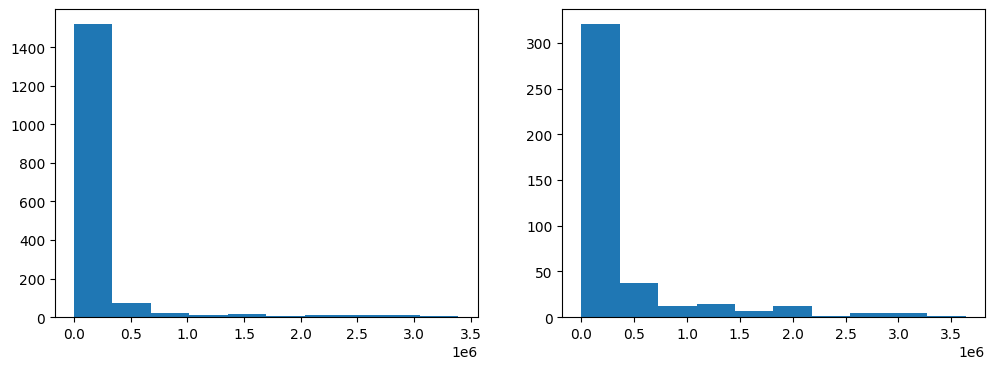

In [73]:
fig, axes = plt.subplots(1, 2, figsize = (12,4))

axes[0].hist(hrv_data.M[hrv_data.y == 0])
axes[1].hist(hrv_data.M[hrv_data.y == 1])

In [74]:
def analysis_mat_expectation(M):
    if M < 0.5:
        return 0
    elif 0.5 <= M < 0.66:
        return 1
    elif 0.66 <= M:
        return 2

In [75]:
hrv_data.M = list(map(lambda m: analysis_mat_expectation(m), M))

In [76]:
def moda_and_amplitude(peaks):
    eps = 0.02

    f = np.zeros(len(peaks))
    count_mode = np.zeros(len(peaks))

    for i in range(len(peaks) - 1):
        f[i] = (peaks[i + 1] - peaks[i])

    for m in range(len(f)):
        count = 0

        for t in range(len(f) - 1):
            if fabs(f[t + 1] - f[m]) / 100 < eps:
                count += 1

        count_mode[m] = count
    max = len(peaks) - 1

    for m in range(len(count_mode)):
        if count_mode[max] < count_mode[m]:
            max = m

    def amplitude_mode():
        return 100 * count_mode[max] / len(peaks)

    return amplitude_mode()

In [77]:
def analysis_amplitude(amplitude):

    if 65 <= amplitude < 100:
        return 0
    else:
        return 1

In [78]:
amplitude = list(map(lambda rpeaks: moda_and_amplitude(rpeaks), R_Peaks))

In [79]:
hrv_data.amplitude = amplitude

(array([25., 73., 70., 76., 61., 35., 32., 13., 16., 14.]),
 array([ 7.14285714, 15.37593985, 23.60902256, 31.84210526, 40.07518797,
        48.30827068, 56.54135338, 64.77443609, 73.0075188 , 81.2406015 ,
        89.47368421]),
 <BarContainer object of 10 artists>)

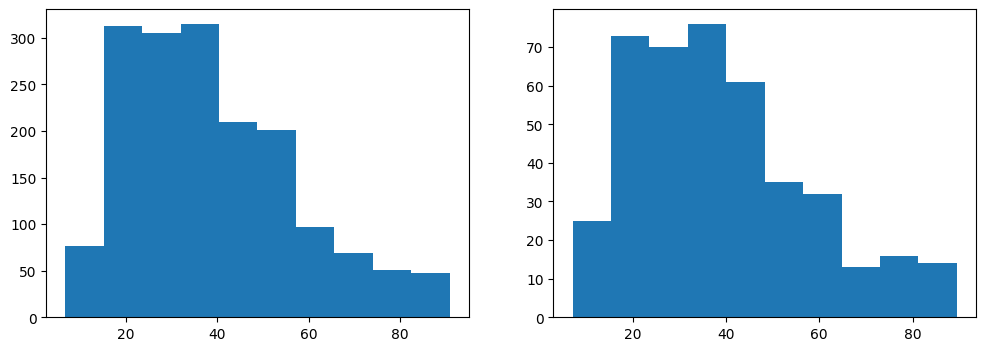

In [80]:
fig, axes = plt.subplots(1, 2, figsize = (12,4))

axes[0].hist(hrv_data.amplitude[hrv_data.y == 0])
axes[1].hist(hrv_data.amplitude[hrv_data.y == 1])

In [81]:
hrv_data.amplitude = list(map(lambda a: analysis_amplitude(a), amplitude))

In [82]:
def SCO(array, index):
  global ECG_data_array
  R_values = [ECG_data_array[index][j] for j in array]
  n = len(R_values)
  mean = np.array(R_values).mean()
  summ = sum([(i - mean) ** 2 for i in R_values])
  return (summ / (n - 1)) ** 0.5

In [83]:
hrv_data.sco = [SCO(R_Peaks[i], i) for i in range(len(R_Peaks))]

In [88]:
def coefficient_covariance(M, SCO):
    return 100 * array(SCO) / array(M)

In [89]:
coefficient_covariance = coefficient_covariance(M, sco_values)

In [94]:
hrv_data.coefficient_cov = coefficient_covariance

## Анализ метаданных

In [43]:
df = pd.read_csv('train/train_meta.csv')

In [44]:
df.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,", I-AVR,",NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
1,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
2,43,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3
3,52,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2
4,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101 entries, 0 to 2100
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        2101 non-null   int64  
 1   patient_id                    2101 non-null   float64
 2   age                           2101 non-null   float64
 3   sex                           2101 non-null   int64  
 4   height                        689 non-null    float64
 5   weight                        905 non-null    float64
 6   nurse                         1947 non-null   float64
 7   site                          2100 non-null   float64
 8   device                        2101 non-null   object 
 9   recording_date                2101 non-null   object 
 10  report                        2101 non-null   object 
 11  scp_codes                     2101 non-null   object 
 12  heart_axis                    1231 non-null   object 
 13  inf

In [46]:
myocard_list = list(gts['myocard'])
df.insert(loc=len(df.columns), column='myocard', value=myocard_list)

In [47]:
d1 = list(df['static_noise'])
d2 = list(df['burst_noise'])
d3 = list(df['electrodes_problems'])
d4 = list(df['baseline_drift'])

In [48]:
df = df[(df.static_noise != d1) & (df.burst_noise != d2) & (df.electrodes_problems != d3) & (df.baseline_drift != d4)]
#удаление строк, содержащих шум, проблемы с электродами, смещение базовой линии/скачок

In [49]:
df[['weight', 'height']] = df[['weight', 'height']].fillna(df[['weight', 'height']].mean())

combo_info = df['weight'].astype(str) + '_' + df['height'].astype(str) + '_' + df['age'].astype(str) + '_' + df['sex'].astype(str)
df.insert(0, 'combo_info', combo_info)
df['combo_info'] = df.groupby('combo_info')['myocard'].transform('mean')
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

In [50]:
df['scp_codes'] = df.groupby('scp_codes')['myocard'].transform('mean') #стандарт для обмена цифровыми ЭКГ

df['infarction_stadium1'] = df.groupby('infarction_stadium1')['myocard'].transform('mean') #стадия инфаркта
df['infarction_stadium2'] = df.groupby('infarction_stadium2')['myocard'].transform('mean') #вторая стадия инфаркта
df[['infarction_stadium1', 'infarction_stadium2']] = df[['infarction_stadium1', 'infarction_stadium2']].fillna(0)
#заполнение пустых значений нулём

df['heart_axis'] = df.groupby('heart_axis')['myocard'].transform('mean') #электрическая ось сердца
oft_value1 = df['heart_axis'].value_counts().idxmax() 
df['heart_axis'] = df['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением

df['device'] = df.groupby('device')['myocard'].transform('mean') #устройство записи
df['report'] = df.groupby('report')['myocard'].transform('mean') #краткий доклад о экг пациента

df['extra_beats'] = df.groupby('extra_beats')['myocard'].transform('mean')
#дополнительные удары сердца(обычно никак не влияют на здоров/болен)
df['extra_beats'] = df['extra_beats'].fillna(0)

oft_value2 = df['nurse'].value_counts().idxmax() #"номер" медсестры
df['nurse'] = df['nurse'].fillna(oft_value2)

oft_value3 = df['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df['validated_by'] = df['validated_by'].fillna(oft_value3)

df['pacemaker'] = df.groupby('pacemaker')['myocard'].transform('mean')
#кардиостимулятор(регулирует функцию электрической проводящей системы сердца)
df['pacemaker'] = df['pacemaker'].fillna(0)

oft_value4 = df['site'].value_counts().idxmax() #"номер" сайта записи
df['site'] = df['site'].fillna(oft_value4)

In [51]:
df.drop(['recording_date', 'filename_lr', 'filename_hr', 'record_name',
         'age', 'sex', 'height', 'weight', 'static_noise', 
         'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )

In [52]:
df.head()

,combo_info,ecg_id,patient_id,nurse,site,device,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,extra_beats,pacemaker,strat_fold,group,myocard
2,0.0,43,11315.0,2.0,0.0,0.034722,0.0,0.027957,0.106589,0.0,0.0,0.0,False,False,True,0.0,0.0,8,3,0
3,0.0,52,18153.0,2.0,0.0,0.034722,0.0,0.095238,0.106589,0.0,0.0,0.0,False,False,True,0.0,0.0,1,2,0
4,0.0,57,16063.0,2.0,0.0,0.034722,0.0,0.027957,0.106589,0.0,0.0,0.0,False,False,True,0.0,0.0,10,3,0
5,0.0,61,14660.0,2.0,0.0,0.034722,0.0,0.027957,0.106589,0.0,0.0,0.0,False,False,True,0.0,0.0,6,1,0
8,0.0,108,11810.0,0.0,0.0,0.034722,0.0,0.000000,0.106589,0.0,0.0,0.0,False,False,True,0.0,0.0,8,3,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1633 entries, 2 to 2100
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   combo_info                    1633 non-null   float64
 1   ecg_id                        1633 non-null   int64  
 2   patient_id                    1633 non-null   float64
 3   nurse                         1633 non-null   float64
 4   site                          1633 non-null   float64
 5   device                        1633 non-null   float64
 6   report                        1633 non-null   float64
 7   scp_codes                     1633 non-null   float64
 8   heart_axis                    1633 non-null   float64
 9   infarction_stadium1           1633 non-null   float64
 10  infarction_stadium2           1633 non-null   float64
 11  validated_by                  1633 non-null   float64
 12  second_opinion                1633 non-null   bool   
 13  initial_

In [54]:
df.corr()['myocard']

combo_info                      0.709896
ecg_id                          0.053619
patient_id                      0.018697
nurse                           0.031836
site                           -0.031896
device                          0.156890
report                          0.956064
scp_codes                       0.908726
heart_axis                      0.292737
infarction_stadium1             0.704535
infarction_stadium2             0.099027
validated_by                   -0.010045
second_opinion                 -0.031151
initial_autogenerated_report    0.033732
validated_by_human             -0.054074
extra_beats                     0.095231
pacemaker                      -0.041069
strat_fold                     -0.019052
group                           0.009375
myocard                         1.000000
Name: myocard, dtype: float64

In [55]:
values = df.values
X = values[:,0:18]
y = values[:,19]
y=y.astype('int')

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.35, random_state=0)

In [65]:
cat = CatBoostClassifier(depth=8,  learning_rate=0.05)
cat.fit(X_train, y_train)

0:	learn: 0.5820665	total: 8.19ms	remaining: 8.18s
1:	learn: 0.4833977	total: 16.3ms	remaining: 8.14s
2:	learn: 0.4146174	total: 25.2ms	remaining: 8.36s
3:	learn: 0.3500509	total: 33ms	remaining: 8.21s
4:	learn: 0.3038877	total: 39.5ms	remaining: 7.86s
5:	learn: 0.2569033	total: 47.1ms	remaining: 7.8s
6:	learn: 0.2242149	total: 54ms	remaining: 7.66s
7:	learn: 0.1940591	total: 60.7ms	remaining: 7.53s
8:	learn: 0.1715296	total: 67.5ms	remaining: 7.44s
9:	learn: 0.1472406	total: 74.4ms	remaining: 7.37s
10:	learn: 0.1289351	total: 81.5ms	remaining: 7.33s
11:	learn: 0.1156603	total: 88.6ms	remaining: 7.3s
12:	learn: 0.1008905	total: 95.4ms	remaining: 7.24s
13:	learn: 0.0928263	total: 103ms	remaining: 7.25s
14:	learn: 0.0807864	total: 110ms	remaining: 7.22s
15:	learn: 0.0719470	total: 115ms	remaining: 7.04s
16:	learn: 0.0667875	total: 122ms	remaining: 7.03s
17:	learn: 0.0599061	total: 129ms	remaining: 7.02s
18:	learn: 0.0544460	total: 136ms	remaining: 7s
19:	learn: 0.0516549	total: 143ms	rem

178:	learn: 0.0017039	total: 1.22s	remaining: 5.61s
179:	learn: 0.0016913	total: 1.23s	remaining: 5.61s
180:	learn: 0.0016811	total: 1.24s	remaining: 5.6s
181:	learn: 0.0016681	total: 1.24s	remaining: 5.59s
182:	learn: 0.0016566	total: 1.25s	remaining: 5.58s
183:	learn: 0.0016461	total: 1.26s	remaining: 5.58s
184:	learn: 0.0016347	total: 1.26s	remaining: 5.57s
185:	learn: 0.0016232	total: 1.27s	remaining: 5.57s
186:	learn: 0.0016123	total: 1.28s	remaining: 5.56s
187:	learn: 0.0016013	total: 1.28s	remaining: 5.55s
188:	learn: 0.0015937	total: 1.29s	remaining: 5.54s
189:	learn: 0.0015855	total: 1.3s	remaining: 5.54s
190:	learn: 0.0015770	total: 1.3s	remaining: 5.53s
191:	learn: 0.0015681	total: 1.31s	remaining: 5.52s
192:	learn: 0.0015574	total: 1.32s	remaining: 5.51s
193:	learn: 0.0015488	total: 1.32s	remaining: 5.51s
194:	learn: 0.0015405	total: 1.33s	remaining: 5.5s
195:	learn: 0.0015319	total: 1.34s	remaining: 5.49s
196:	learn: 0.0015241	total: 1.34s	remaining: 5.48s
197:	learn: 0.00

343:	learn: 0.0008349	total: 2.65s	remaining: 5.06s
344:	learn: 0.0008322	total: 2.66s	remaining: 5.05s
345:	learn: 0.0008294	total: 2.67s	remaining: 5.04s
346:	learn: 0.0008266	total: 2.68s	remaining: 5.04s
347:	learn: 0.0008239	total: 2.69s	remaining: 5.04s
348:	learn: 0.0008212	total: 2.7s	remaining: 5.03s
349:	learn: 0.0008185	total: 2.71s	remaining: 5.03s
350:	learn: 0.0008160	total: 2.71s	remaining: 5.02s
351:	learn: 0.0008133	total: 2.73s	remaining: 5.02s
352:	learn: 0.0008108	total: 2.73s	remaining: 5.01s
353:	learn: 0.0008083	total: 2.74s	remaining: 5s
354:	learn: 0.0008056	total: 2.75s	remaining: 5s
355:	learn: 0.0008032	total: 2.76s	remaining: 4.99s
356:	learn: 0.0008007	total: 2.77s	remaining: 4.99s
357:	learn: 0.0007981	total: 2.78s	remaining: 4.98s
358:	learn: 0.0007956	total: 2.79s	remaining: 4.97s
359:	learn: 0.0007931	total: 2.79s	remaining: 4.97s
360:	learn: 0.0007906	total: 2.81s	remaining: 4.96s
361:	learn: 0.0007881	total: 2.81s	remaining: 4.96s
362:	learn: 0.00078

521:	learn: 0.0005219	total: 4.26s	remaining: 3.9s
522:	learn: 0.0005219	total: 4.27s	remaining: 3.9s
523:	learn: 0.0005210	total: 4.28s	remaining: 3.89s
524:	learn: 0.0005199	total: 4.29s	remaining: 3.88s
525:	learn: 0.0005188	total: 4.3s	remaining: 3.87s
526:	learn: 0.0005188	total: 4.31s	remaining: 3.87s
527:	learn: 0.0005182	total: 4.32s	remaining: 3.86s
528:	learn: 0.0005174	total: 4.32s	remaining: 3.85s
529:	learn: 0.0005163	total: 4.33s	remaining: 3.84s
530:	learn: 0.0005153	total: 4.34s	remaining: 3.83s
531:	learn: 0.0005142	total: 4.36s	remaining: 3.83s
532:	learn: 0.0005133	total: 4.37s	remaining: 3.83s
533:	learn: 0.0005124	total: 4.38s	remaining: 3.82s
534:	learn: 0.0005113	total: 4.38s	remaining: 3.81s
535:	learn: 0.0005104	total: 4.39s	remaining: 3.8s
536:	learn: 0.0005093	total: 4.4s	remaining: 3.8s
537:	learn: 0.0005083	total: 4.41s	remaining: 3.79s
538:	learn: 0.0005072	total: 4.42s	remaining: 3.78s
539:	learn: 0.0005061	total: 4.43s	remaining: 3.77s
540:	learn: 0.0005

684:	learn: 0.0004530	total: 5.68s	remaining: 2.61s
685:	learn: 0.0004530	total: 5.68s	remaining: 2.6s
686:	learn: 0.0004530	total: 5.69s	remaining: 2.59s
687:	learn: 0.0004530	total: 5.7s	remaining: 2.58s
688:	learn: 0.0004530	total: 5.71s	remaining: 2.58s
689:	learn: 0.0004530	total: 5.72s	remaining: 2.57s
690:	learn: 0.0004530	total: 5.72s	remaining: 2.56s
691:	learn: 0.0004530	total: 5.73s	remaining: 2.55s
692:	learn: 0.0004530	total: 5.74s	remaining: 2.54s
693:	learn: 0.0004530	total: 5.75s	remaining: 2.54s
694:	learn: 0.0004530	total: 5.76s	remaining: 2.53s
695:	learn: 0.0004530	total: 5.76s	remaining: 2.52s
696:	learn: 0.0004530	total: 5.77s	remaining: 2.51s
697:	learn: 0.0004530	total: 5.78s	remaining: 2.5s
698:	learn: 0.0004530	total: 5.79s	remaining: 2.49s
699:	learn: 0.0004530	total: 5.8s	remaining: 2.48s
700:	learn: 0.0004530	total: 5.8s	remaining: 2.48s
701:	learn: 0.0004530	total: 5.81s	remaining: 2.47s
702:	learn: 0.0004530	total: 5.82s	remaining: 2.46s
703:	learn: 0.000

857:	learn: 0.0004519	total: 7.09s	remaining: 1.17s
858:	learn: 0.0004519	total: 7.1s	remaining: 1.17s
859:	learn: 0.0004519	total: 7.11s	remaining: 1.16s
860:	learn: 0.0004519	total: 7.12s	remaining: 1.15s
861:	learn: 0.0004519	total: 7.13s	remaining: 1.14s
862:	learn: 0.0004519	total: 7.13s	remaining: 1.13s
863:	learn: 0.0004519	total: 7.14s	remaining: 1.12s
864:	learn: 0.0004519	total: 7.15s	remaining: 1.12s
865:	learn: 0.0004519	total: 7.16s	remaining: 1.11s
866:	learn: 0.0004519	total: 7.17s	remaining: 1.1s
867:	learn: 0.0004519	total: 7.17s	remaining: 1.09s
868:	learn: 0.0004519	total: 7.18s	remaining: 1.08s
869:	learn: 0.0004519	total: 7.19s	remaining: 1.07s
870:	learn: 0.0004519	total: 7.2s	remaining: 1.07s
871:	learn: 0.0004519	total: 7.21s	remaining: 1.06s
872:	learn: 0.0004519	total: 7.21s	remaining: 1.05s
873:	learn: 0.0004519	total: 7.22s	remaining: 1.04s
874:	learn: 0.0004519	total: 7.23s	remaining: 1.03s
875:	learn: 0.0004519	total: 7.24s	remaining: 1.02s
876:	learn: 0.0

In [66]:
f1_score(y_train, cat.predict(X_train), average = 'macro')

1.0

In [67]:
f1_score(y_test, cat.predict(X_test), average = 'macro')

0.9851074451555726